# Regularized Linear Regression and Bias vs. Variance

## 1 Regularized linear regression

Implemented regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir.

### 1.1 Visualizing the dataset

The dataset is divided into three parts:
* a **training** set that the model will learn on: $X$, $y$
* a **cross validation** set for determining the regularization parameter: $Xval$, $yval$
* a **test** set for evaluating performance, should remain unseen to prevent data leakage: $Xtest$, $ytest$

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline 

In [2]:
dataset = loadmat('ex5data1.mat')
print(dataset['__header__'])
X, y = dataset['X'], dataset['y']
Xval, yval = dataset['Xval'], dataset['yval']
Xtest, ytest = dataset['Xtest'], dataset['ytest']
print()
print(f'size of X: {X.shape}')
print(f'size of y: {y.shape}')
print(f'size of Xval: {Xval.shape}')
print(f'size of yval: {yval.shape}')
print(f'size of Xtest: {Xtest.shape}')
print(f'size of ytest: {ytest.shape}')

b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011'

size of X: (12, 1)
size of y: (12, 1)
size of Xval: (21, 1)
size of yval: (21, 1)
size of Xtest: (21, 1)
size of ytest: (21, 1)


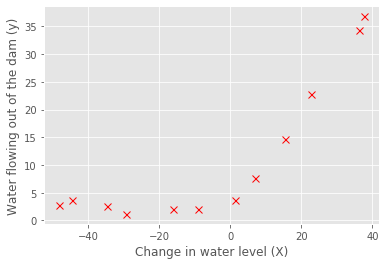

In [3]:
plt.plot(X.ravel(), y.ravel(), 
         marker='x', markersize=7, c='red', 
         linestyle='None')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### 1.2 Regularized linear regression cost function


The regularized linear regression has the following form of the cost function:

$$ J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
where $\lambda$ is regularization parameter which controls the degree of regularization and helps preventing overfitting.

In [4]:
def cost(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    h = X @ theta
    J = 1/(2*m) * np.sum((h-y)**2)
    reg = _lambda/(2*m) * np.sum(theta[1:]**2)
    return J + reg

In [5]:
theta = np.array([1,1]).reshape(-1,1)
X_bias = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
J = cost(theta, X_bias, y, _lambda=1)

print(f'cost at theta=[1; 1]: {J}')
print('this value should be about 303.993192')

cost at theta=[1; 1]: 303.9931922202643
this value should be about 303.993192


### 1.3 Regularized linear regression gradient

The partial derivative of regularized linear regression's cost for $\theta_{j}$ is defined as:

$
\frac{\partial J(\theta)}{\partial \theta_{0}} = \frac{1}{m} \sum_{i=1}^{m}(h_{\theta}(x^{(i)} - y^{(i)})x_{j}^{(i)}
$ for $j=0$

$
\frac{\partial J(\theta)}{\partial \theta_{0}} = (\frac{1}{m} \sum_{i=1}^{m}(h_{\theta}(x^{(i)} - y^{(i)})x_{j}^{(i)}) + \frac{\lambda}{m}\theta_{j}
$ for $j \geq 1$

In [6]:
def grad(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    h = X @ theta
    g = 1/m * X.T @ (h - y)
    g[1:] = g[1:] + (_lambda * theta[1:] / m)
    return g.flatten()

In [7]:
g = grad(theta, X_bias, y, _lambda=1)

print(f'gradient at theta=[1; 1]: {g}')
print('this value should be [-15.30; 598.25]')

gradient at theta=[1; 1]: [-15.30301567 598.25074417]
this value should be [-15.30; 598.25]


### 1.4 Fitting linear regression

Training is done using function *fmincg* to optimize the cost function, or to find thetas which result in minimum of the defined cost function.

In [8]:
def train(X, y, _lambda):
    # X should have already bias init
    init_theta = np.zeros((X.shape[1], 1))
    theta, theta_history = fmin_cg(f = cost,
                                   x0 = init_theta,
                                   fprime = grad,
                                   args = (X, y, _lambda),
                                   maxiter = 200,
                                   disp = 0,
                                   retall = 1,) # disable retall for no theta_history
    return theta, theta_history

In [9]:
_lambda = 0 # no regularization will be applied
theta, theta_history = train(X_bias, y, _lambda)

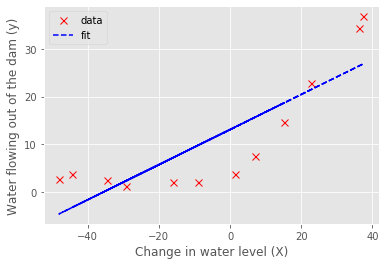

In [10]:
plt.plot(X, y, label='data',
         marker='x', markersize=7, c='red', linestyle='None')
plt.plot(X, X_bias @ theta, label='fit',
         c = 'blue', linestyle='--',)
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(loc='best')
plt.show()

## 2 Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to **underfit**, while models with high variance **overfit** to the training data.

### 2.1 Learning curves

Learning curve plots training and cross validation error as a function of training set size. 

To plot the learning curve, training and cross validation set error needs to be plotted for different *training* set sizes. 
This does not require applying any regularization to the cost function, which means cost functions are defined as follows:

$$
J_{train}(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2
$$

$$
J_{cv}(\theta) = \frac{1}{2m_{cv}}\sum_{j=1}^{m_{cv}}(h_{\theta}(x^{(j)}) - y^{(j)})^2
$$

When the training set error is computed, only subset of current iteration should be used; however, for the cross validation error, the entire cross validation set should be used.

In [11]:
def learningCurve(X, y, Xval, yval, _lambda):
    m = X.shape[0]
    error_train = np.zeros((m+1, 1))
    error_cv = np.zeros((m+1, 1))
    
    for i in range(1, m+1):
        theta, theta_history = train(X[:i, :], y[:i], _lambda)
        error_train[i] = cost(theta, X[:i, :], y[:i], _lambda)
        error_cv[i] = cost(theta, Xval, yval, _lambda)
    return error_train, error_cv

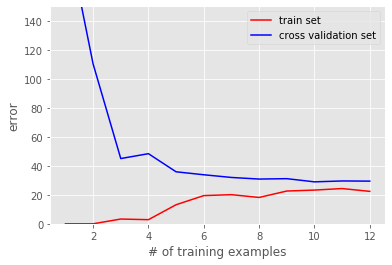

In [12]:
_lambda = 0 # NO regularization here, we want to inspect bias and variance
Xval_bias = np.concatenate((np.ones((Xval.shape[0], 1)), Xval), axis=1)
error_train, error_cv = learningCurve(X_bias, y, Xval_bias, yval, _lambda)

size_of_training_set = [i for i in range(1, len(y)+1)]
plt.plot(size_of_training_set, error_train[1:], c='red', label='train set')
plt.plot(size_of_training_set, error_cv[1:], c='blue', label='cross validation set')
plt.xlabel('# of training examples')
plt.ylabel('error')
plt.ylim([0, 150])
plt.legend(loc='best')
plt.show()

In [13]:
print(f'#\ttrain error\tcv error')
for i, s in enumerate(size_of_training_set):
    print(f'{i+1}\t{np.round(error_train[i+1].squeeze(), 4)}\t\t{np.round(error_cv[i+1].squeeze(), 4)}')

#	train error	cv error
1	0.0		205.1211
2	0.0		110.3004
3	3.2866		45.0102
4	2.8427		48.3689
5	13.154		35.8651
6	19.444		33.83
7	20.0985		31.971
8	18.1729		30.8624
9	22.6094		31.136
10	23.2615		28.9362
11	24.3172		29.5514
12	22.3739		29.4338


Learning curve shows extremely high cost function for both the train error and cross validation error. This reflect **high bias** problem in the model - the linear regression model is too simple and is unable to fit dataset well. 
More complex model, with more features, should be applied on this data.

# 3 Polynomial regression

When the resulting model is too simple, it often results in underfitting (high bias). Here, the polynomial regression will be used. In its simplest form, the general hypothesis for the polynomial regression has the following form:

$$
h_{\theta}(x) = \theta_{0} + \theta_{1}x + \theta_{2}x^2 + ... + \theta_{p}x^p = \sum_{i=0}^{p}\theta_{i}x^i 
$$

On the existing dataset, new, higher power features can be added with function that maps the original training set of size $m \times 1$ to a $m \times p$ matrix where column 1 holds the original values of the dataset, column 2 holds the values of squared values of dataset and so on. 

In [14]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X-mu, axis=0, ddof=1)
    return (X-mu)/sigma, mu, sigma

def polyFeatures(X, p):
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:, i] = np.power(X.ravel(), i+1)
    return X_poly

In [15]:
p = 8
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly) # normalization
X_poly_bias = np.concatenate((np.ones((X.shape[0], 1)), X_poly), axis=1)

X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test_bias = np.concatenate((np.ones((X_poly_test.shape[0], 1)), X_poly_test), axis=1)

X_poly_cv = polyFeatures(Xtest, p)
X_poly_cv -= mu
X_poly_cv /= sigma
X_poly_cv_bias = np.concatenate((np.ones((X_poly_cv.shape[0], 1)), X_poly_cv), axis=1)

In [16]:
print(f'normalized training example 1:\n {X_poly_bias[0, :].reshape(-1,1)}')

normalized training example 1:
 [[ 1.        ]
 [-0.36214078]
 [-0.75508669]
 [ 0.18222588]
 [-0.70618991]
 [ 0.30661792]
 [-0.59087767]
 [ 0.3445158 ]
 [-0.50848117]]


### 3.1 Learning polynomial regression

Even though there are polynomail terms in the training set, this is still linear regression optimization problem: the polynomial terms have simply turnedd into features that we can use for linear regression.

In [17]:
def plotFit(X, y, mu, sigma, theta, p):
    plt.plot(X, y, label='data',
         marker='x', markersize=7, linestyle='None',)

    _x = np.linspace(min(X) - 25, max(X) + 25, 100).reshape(-1, 1)
    X_poly = polyFeatures(_x, p)
    # normalization using mu(X) and sigma(X) from original dataset
    X_poly -= mu
    X_poly /= sigma
    X_poly_bias = np.concatenate((np.ones((X_poly.shape[0], 1)), X_poly), axis=1)

    plt.plot(_x, X_poly_bias @ theta, label='fit',
             c='b', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

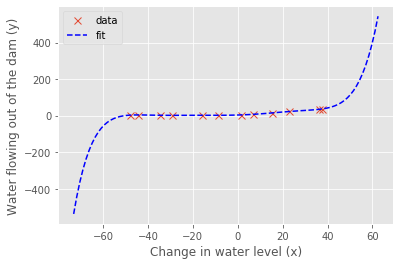

In [18]:
theta, theta_history = train(X_poly_bias, y, _lambda=0)
plotFit(X, y, mu, sigma, theta, p)
plt.show()

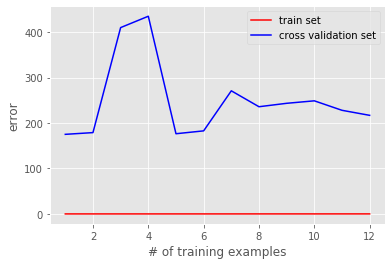

In [19]:
_lambda = 0
error_train, error_cv = learningCurve(X_poly_bias, y, X_poly_cv_bias, yval, _lambda)

size_of_training_set = [i for i in range(1, len(y)+1)]
plt.plot(size_of_training_set, error_train[1:], c='red', label='train set')
plt.plot(size_of_training_set, error_cv[1:], c='blue', label='cross validation set')
plt.xlabel('# of training examples')
plt.ylabel('error')
plt.legend(loc='best')
plt.show()

### 3.3 Selecting $\lambda$ using a cross validation set 

In [20]:
def validationCurve(X, y, Xval, yval):
    _lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = np.zeros((len(_lambda_vec), 1))
    error_cv = np.zeros((len(_lambda_vec), 1))
    
    for i, _lambda in enumerate(_lambda_vec):
        theta, theta_history = train(X, y, _lambda)
        error_train[i] = cost(theta, X, y, 0)
        error_cv[i] = cost(theta, Xval, yval, 0)
    return _lambda_vec, error_train, error_cv

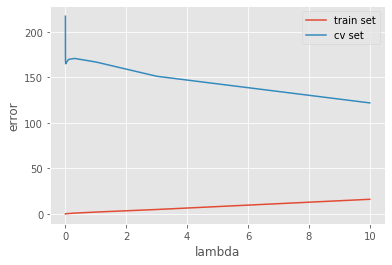

In [21]:
_lambdas, error_train, error_cv = validationCurve(X_poly_bias, y, X_poly_cv_bias, yval)
plt.plot(_lambdas, error_train, label='train set')
plt.plot(_lambdas, error_cv, label='cv set')
plt.xlabel('lambda')
plt.ylabel('error')
#plt.ylim([0, 20])
plt.legend()
plt.show()

In [22]:
print(f'lambda\t\ttrain error\t validation error')
for i, _lambda in enumerate(_lambdas):
    print(f'{_lambda}\t\t{error_train[i]}\t{error_cv[i]}')

lambda		train error	 validation error
0		[0.04269739]	[216.92709094]
0.001		[0.11312835]	[177.30879669]
0.003		[0.17099095]	[167.93773111]
0.01		[0.221549]	[164.76086909]
0.03		[0.2818552]	[166.08777363]
0.1		[0.45930336]	[169.50329191]
0.3		[0.92175858]	[170.65102369]
1		[2.0761793]	[166.72949474]
3		[4.90134756]	[151.07556335]
10		[16.09220998]	[121.83859338]
